In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import Sequential 
#from tensorflow.keras.layers import * 
#import efficientnet.tfkeras as efn

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-11-19 13:28:31.846023: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-19 13:28:33.638316: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.0de2b4431c6572ee74152a7ee0cd3fb1534e4a95.so
2022-11-19 13:28:33.638485: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-11-19 13:28:33.653107: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-11-19 13:28:35.698150: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [3]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
train = pd.read_csv('../../DATA/kaggle_dsets/histopath_detection/train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [12]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [6]:
train.id = train.id + '.tif'

In [13]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [14]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

,0,1
label,0.594969,0.405031


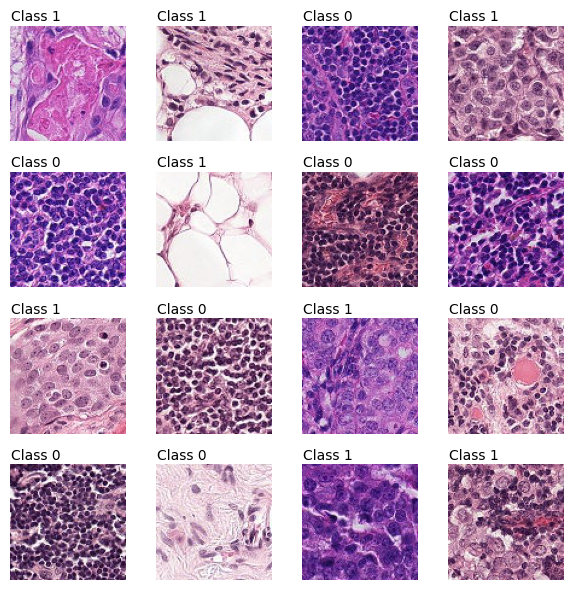

In [15]:
train_path = "../../DATA/kaggle_dsets/histopath_detection/train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'../../DATA/kaggle_dsets/histopath_detection/train/{row.id}')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

In [18]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [21]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [22]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

688
688


In [23]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(96,96,3), include_top=False, weights='imagenet')

cnn = Sequential([
    base_model,
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation='softmax')
])

cnn.summary()

2022-11-19 13:40:47.839839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 13:40:47.841339: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 2070)
2022-11-19 13:40:48.786197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 13:40:48.786266: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-11-19 13:40:48.786295: I tensorflow/core/common_runtime/pluggable_device/pluggable

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 64)                737344    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               1

In [24]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [25]:
h1 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 40,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 0
)

Epoch 1/40


2022-11-19 13:41:53.223083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 13:41:53.608931: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node gradient_tape/sequential/efficientnetb0/top_conv/Conv2D/Conv2DBackpropInput-0-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='XLA_CPU_JIT'; label='host'; T in [DT_INT32, DT_INT64]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-11-19 13:41:53.610211: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node gradient_tape/sequential/eff

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/efficientnetb0/stem_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3540/2265906370.py", line 7, in <module>
      verbose = 1
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 595, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/control_flow_util.py", line 106, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 581, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor)
Node: 'sequential/efficientnetb0/stem_bn/FusedBatchNormV3'
Detected at node 'sequential/efficientnetb0/stem_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/lachlan/.pyenv/versions/3.7.13/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3540/2265906370.py", line 7, in <module>
      verbose = 1
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 595, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/utils/control_flow_util.py", line 106, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 581, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor)
Node: 'sequential/efficientnetb0/stem_bn/FusedBatchNormV3'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  DML doesn't support exponential_avg_factor != 1 at the moment
	 [[{{node sequential/efficientnetb0/stem_bn/FusedBatchNormV3}}]]
	 [[sequential/efficientnetb0/block4b_drop/Shape-0-0-DataFormatVecPermuteNCHWToNHWC-LayoutOptimizer/_76]]
  (1) INVALID_ARGUMENT:  DML doesn't support exponential_avg_factor != 1 at the moment
	 [[{{node sequential/efficientnetb0/stem_bn/FusedBatchNormV3}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_20248]